# Convolutional Autoencoders on Flower Dataset

I built a Convolutional Autoencoder for reconstructing flower images.

In [50]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import ZeroPadding2D

In [51]:
# check whether GPU is avaiable to use
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  0
/bin/bash: line 1: nvidia-smi: command not found


## 1. Dataset Preparation

## To Run in Google Colab

In [52]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

# List MyDrive before t
!ls /content/drive/MyDrive/



# Open dataset from zipfile
zip_path = "/content/drive/MyDrive/flowers.zip"
extract_path = '/content/drive/MyDrive/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")



# lists all files in Google Drive
!ls /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CNN_AutoEncoder.ipynb  flowers_train_validation  flowers.zip  VAE.ipynb  WGAN.ipynb
Dataset unzipped successfully!
CNN_AutoEncoder.ipynb  flowers_train_validation  flowers.zip  VAE.ipynb  WGAN.ipynb


## Run on Local Machine

In [53]:
'''

import os
import zipfile

# Define the paths for the zip file and extraction directory
zip_path = r"C:\path\to\your\flowers.zip"  # Update this to your zip file's actual path
extract_path = r"C:\path\to\extract\directory"  # Update this to your desired extraction directory

# Ensure the extraction path exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset unzipped successfully!")
except FileNotFoundError:
    print(f"Error: The file {zip_path} does not exist.")
except zipfile.BadZipFile:
    print(f"Error: The file {zip_path} is not a valid zip file.")

'''


'\n\nimport os\nimport zipfile\n\n# Define the paths for the zip file and extraction directory\nzip_path = r"C:\\path\to\\your\x0clowers.zip"  # Update this to your zip file\'s actual path\nextract_path = r"C:\\path\to\\extract\\directory"  # Update this to your desired extraction directory\n\n# Ensure the extraction path exists\nos.makedirs(extract_path, exist_ok=True)\n\n# Extract the zip file\ntry:\n    with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n        zip_ref.extractall(extract_path)\n    print("Dataset unzipped successfully!")\nexcept FileNotFoundError:\n    print(f"Error: The file {zip_path} does not exist.")\nexcept zipfile.BadZipFile:\n    print(f"Error: The file {zip_path} is not a valid zip file.")\n\n'

In [54]:
# Google CoLab
train_dir  = '/content/drive/MyDrive/flowers_train_validation/train'
validation_dir = '/content/drive/MyDrive/flowers_train_validation/validation'

# Local Machine
#Train = 'C:/path to local drive for extracted files /flowers_train_validation/train'
#Validation = 'C:/path to local drive for extracted files /flowers_train_validation/validation'
TARGET_SIZE=(150,150)

### 1.2: Data Preprocessing

#### 1.2.1 Use a scratch version for constructing TF Dataset

**Note**: the following cell demonstrates a scratch version of constructing TF training/validation Dataset, so you get the idea how dataset are constructed through reading raw images, forming tuples of (image, image), preprocess (normalize 1/255.0), forming batches...

In [55]:
import tensorflow as tf
import os

# Set paths for the dataset manually
train_dir = '/content/drive/MyDrive/flowers_train_validation/train'
validation_dir = '/content/drive/MyDrive/flowers_train_validation/validation'
test_dir ='/content/drive/MyDrive/flowers_train_validation/test'

IMG_SIZE = (150, 150)
BATCH_SIZE = 128

# Helper function to process a single image
def process_image(file_path, label):
    # Load the raw image from file as a tensor
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # or decode_png() for .png files
    img = tf.image.resize(img, IMG_SIZE)  # Resize the image
    img = img / 255.0  # Normalize to [0, 1]

    # Return image twice for autoencoder input-output pair
    return img, img

# Get class names from the directory
class_names = sorted(os.listdir(train_dir))

# Create a dictionary to map class names to integer labels
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}

def get_dataset(dir_path):
    # List all image files in the directory
    image_paths = []
    labels = []
    dataset_size = 0  # To keep track of the dataset size

    valid_extensions = ('.jpg', '.jpeg', '.png')  # Define valid image extensions

    for class_name in class_names:
        class_dir = os.path.join(dir_path, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.endswith(valid_extensions):  # Only process image files
                image_paths.append(os.path.join(class_dir, img_file))
                labels.append(class_to_index[class_name])
                dataset_size += 1  # Increment the dataset size for each image

    # Convert the lists to TensorFlow tensors
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)

    # Create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Parallel loading

    return dataset, dataset_size  # Return the dataset and the size

# Load the training and validation datasets with sizes
train_dataset, train_size = get_dataset(train_dir)
validation_dataset, validation_size = get_dataset(validation_dir)

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the sizes of the datasets
print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {validation_size}")

type(train_dataset)
print(type(train_dataset))

Training dataset size: 3454
Validation dataset size: 865
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 1.2.2 Using image_dataset_from_directory for constructing training dataset

*Read image_dataset_from_directory**:

- Set image_size to be 150 as our flower images are
- set batch_size to be 128
- Modify the arguments within image_dataset_from_directory if necessary to ensure it reads image files sitting in the train folder.

In [56]:
IMAGE_SIZE = 150
BATCH_SIZE = 128

In [57]:
# Load the data
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # this is the train dataset folder on your google colab
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

print(type(train_data))

Found 3458 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 1.2.3 Preprocessing images


In [58]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img, img

In [59]:
# the training dataset has been processed for model training
train_data = train_data.map(lambda x: preprocess(x))

### 1.3 Checking train data

**Note**: If all the above steps are set correctly, you should be able  to see the images read frm training data.

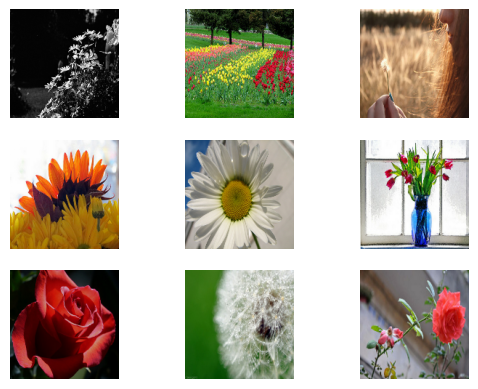

In [60]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for batch, batch in train_data.take(1):
    # Iterate through images in the batch
    for i in range(9):  # Show 9 images for preview
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().clip(0, 1))  # Clip values to [0, 1] range
        plt.axis('off')
    plt.show()


## 2. Define the autoencoder Model

I created a CNN to built a AutoEncoder

### 2.1 The encoder

**Encoder**:

- Define the encoder which contains conv2d and max pooling layers.


In [61]:
def encoder(inputs):
    '''Defines the encoder with Conv2D and MaxPooling layers.'''
    conv_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv_1)
    conv_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D((2, 2), padding='valid')(conv_2)
    return max_pool_2

In [62]:
# this is optional, you may have this if you follow scripts of 07_4_FashionMNIST_CNNAutoEncoder.ipynb
def bottle_neck(inputs):
    '''Defines the bottleneck.'''
    bottleneck = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    encoder_output = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(bottleneck)
    return bottleneck, encoder_output

### 2.2 The decoder

**Decoder**:

- **Mirror the Encoder Architecture**. If the encoder uses convolutional layers, the decoder generally uses transposed convolutional layers (Conv2DTranspose).
- **Activation Functions**. The final layer should use an activation function that matches the data characteristics, i.e., Sigmoid for pixel values in the range [0, 1]. Intermediate layers can use ReLU or LeakyReLU.
- **Final Output Layer**: In general, it should have the same number of channels and spatial dimensions as the original input image i.e., (150,150,0).

In [63]:
from threading import active_count
def decoder(inputs):
    '''Defines the decoder path to upsample back to the original image size.'''
    conv_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)

    # Second upsampling and convolution
    up_sample_2 = tf.keras.layers.UpSampling2D((2, 2))(conv_4)
    conv_5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up_sample_2)

    # Final upsampling to match original dimensions, then padding to achieve 150x150
    up_sample_3 = tf.keras.layers.UpSampling2D((2, 2))(conv_5)
    conv_6 = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up_sample_3)
    padded_output = tf.keras.layers.ZeroPadding2D(((2, 0), (2, 0)))(conv_6)

    return padded_output

### 2.3 Autoencoder

**AutoEncoder**:

- **Encoder model**: This model can be used for predicing latent space
- **Decoder model**: This model can be used for generating new images. This model is optional if no imgae generation task is performed.
- **Autoencoder model**: This model will be used for model fitting and model prediction.


In [64]:
def convolutional_auto_encoder():
    '''Builds the entire autoencoder model.'''
    inputs = tf.keras.layers.Input(shape=(150, 150, 3))
    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)

    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    decoder_model = tf.keras.Model(inputs=bottleneck_output, outputs=decoder_output)

    return model, encoder_model, decoder_model

In [65]:
# you may need to chnage the following code depending on  how you implement the convolutional_auto_encoder above.
convolutional_model, convolutional_encoder_model, convolutional_decoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 37, 37, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 37, 37, 256)       2951

## 3. Compile and Train the model

**Compile and Train the model**:

- Configure model compile optimizer and loss function which are:
  - optimizer: adam
  - loss: mse (mean squared error)


In [66]:
# your model compile and model fitting
train_steps = train_size // BATCH_SIZE
valid_steps = validation_size // BATCH_SIZE
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
conv_model_history = convolutional_model.fit(train_dataset,
                                             steps_per_epoch=train_steps,
                                             validation_data=validation_dataset,
                                             validation_steps=valid_steps,
                                             epochs=10)

Epoch 1/10
26/26 [==============================] - 94s 4s/step - loss: 0.0527 - val_loss: 0.0253
Epoch 2/10
 1/26 [>.............................] - ETA: 1:23 - loss: 0.0293

26/26 [==============================] - 8s 181ms/step - loss: 0.0293 - val_loss: 0.0225


## 4. Display sample results

### 4.1 Visualization functions

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def display_one_row(disp_images, offset, shape=(150, 150,3)):
    '''Display sample outputs in one row.'''
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image)

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(37,37,3)):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(150,150,3))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(150,150,3))

### 4.2 Prepare testing images

In [68]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# load the dataset
# take 1 batch of the dataset
test_dataset = train_data.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
    output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 150,150,3))

### 4.3 Visualize original images, embeddings and reconstructed images

1/1 [==============================] - 0s 121ms/step


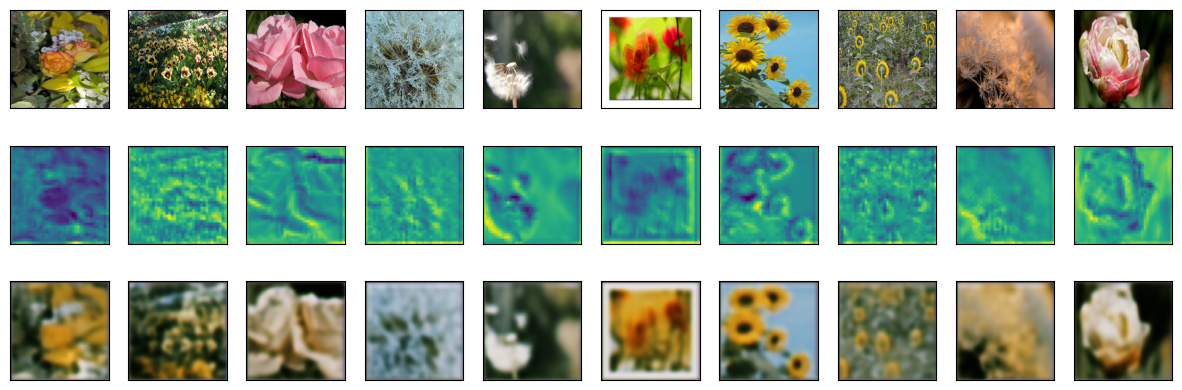

In [69]:
# Your source code below
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(37,37))